In [11]:
import ee
import os
import re
import csv
import glob
import geemap
import datetime
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import mean
import geopandas as gpd
import matplotlib.colors
from scipy.stats import norm
from matplotlib import gridspec
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Get today's date and create a directory name in the format "yyyyMMdd"
today = datetime.date.today()
dir_in = today.strftime("%Y%m%d")
out_dir = 'G:/001Project/Output/Figures/' + dir_in + '/'

# Create the output directory if it doesn't exist
# os.makedirs(out_dir, exist_ok=True)

# Check if the directory already exists, and if not, create it
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

## No Aggregation

      Year      Data   Mean    Std  Median     Q1     Q3
0  6 Years  Sections  74.22  35.69   73.18  53.97  91.89


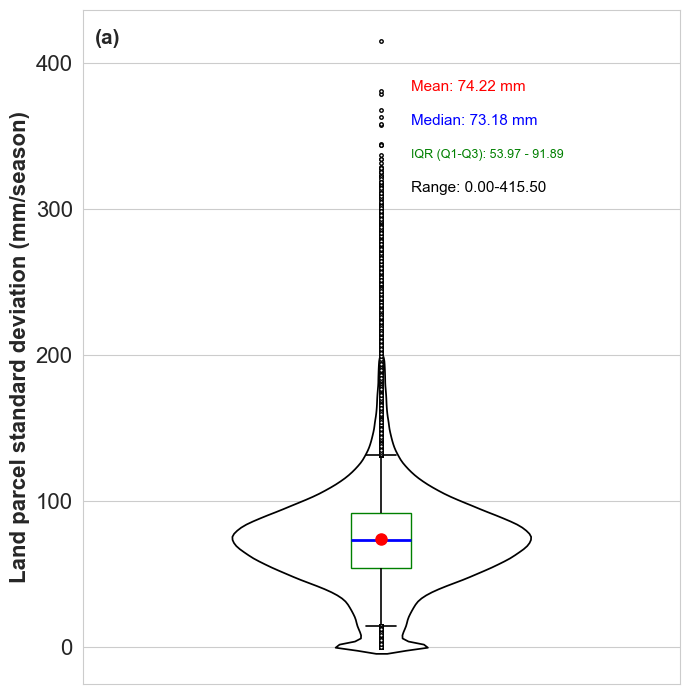

In [11]:
# Define color properties
violin_color = '#ffffff'  # White
boxplot_edge_color = 'green'  # Boxplot outline
boxplot_fill_color = 'white'
mean_marker_color = 'red'
outlier_marker_color = 'black'
median_line_color = 'blue'

# Define the path to the CSV files for the section-year using the wildcard (*) to select multiple files that match the pattern.
section_file = 'G:/001Project/Output/Sheets/cleaned_Results/irrigation_wUse/Section_IWU_*.csv'

def process_data(file_pattern, groupby_column='COUNTY'):
    all_data = []
    for file in glob.glob(file_pattern):
        year = file.split('_')[-1].split('.')[0]

        data = pd.read_csv(file)
        model_columns = ['DISALEXI_DAYMET', 'EEMETRIC_DAYMET', 'GEESEBAL_DAYMET', 'PTJPL_DAYMET', 'SIMS_DAYMET', 'SSEBOP_DAYMET',
                         'DISALEXI_gridMET', 'EEMETRIC_gridMET', 'GEESEBAL_gridMET', 'PTJPL_gridMET', 'SIMS_gridMET', 'SSEBOP_gridMET',
                         'DISALEXI_IMERG', 'EEMETRIC_IMERG', 'GEESEBAL_IMERG', 'PTJPL_IMERG', 'SIMS_IMERG', 'SSEBOP_IMERG',
                         'DISALEXI_NLDAS', 'EEMETRIC_NLDAS', 'GEESEBAL_NLDAS', 'PTJPL_NLDAS', 'SIMS_NLDAS', 'SSEBOP_NLDAS',
                         'DISALEXI_PRISM', 'EEMETRIC_PRISM', 'GEESEBAL_PRISM', 'PTJPL_PRISM', 'SIMS_PRISM', 'SSEBOP_PRISM']
        data[model_columns] = data[model_columns].clip(lower=0)
        if groupby_column:
            data = data.groupby(groupby_column)[model_columns].mean()
        data['STD'] = data[model_columns].std(axis=1)
        data['Year'] = year
        all_data.append(data)
    return pd.concat(all_data)

section_data = process_data(section_file, groupby_column=None)

fig, ax = plt.subplots(figsize=(7, 7.04))

# Plot section variability
sns.violinplot(y=section_data[section_data['STD'] < 200]['STD'], width=0.5, inner=None, ax=ax, color=violin_color, edgecolor='black')
for c in ax.collections:
    if isinstance(c, matplotlib.collections.PathCollection):
        c.set_edgecolor('black')
        c.set_facecolor('#fffff')
        c.set_alpha(1)

sns.boxplot(data=section_data, y='STD', saturation=0.5, width=0.1, color=boxplot_fill_color, boxprops={'zorder': 2, 'edgecolor': boxplot_edge_color}, showmeans=True,
            meanprops={'marker': 'o',  # Represent mean by a red "o"
                       'markerfacecolor': mean_marker_color,
                       'markeredgecolor': mean_marker_color,
                       'markersize': '8'},
            medianprops={'color': median_line_color, 'linewidth': 2},  # Represent median by a blue line
            whiskerprops={'color': 'black', 'linewidth': 1.2},
            capprops={'color': 'black', 'linewidth': 1.2},
            whis=[5, 95],
            flierprops={'markeredgecolor': 'black', 'markerfacecolor': 'white', 'markersize': 2.5},
            ax=ax)

ax.set_ylabel('Land parcel standard deviation (mm/season)', fontweight='bold', fontsize=16)
ax.tick_params(labelsize=16, which='both', width=2)
ax.text(0.02, 0.95, '(a)', transform=ax.transAxes, fontsize=15, fontweight='bold')

section_stats = section_data['STD'].describe()
section_mean = section_stats['mean']
section_std = section_stats['std']
section_median = section_stats['50%']
section_q1 = section_stats['25%']
section_q3 = section_stats['75%']
section_min = section_stats['min']
section_max = section_stats['max']

ax.text(0.55, 0.88, f'Mean: {section_mean:.2f} mm', transform=ax.transAxes, fontsize=11, color='red')
ax.text(0.55, 0.83, f'Median: {section_median:.2f} mm', transform=ax.transAxes, fontsize=11, color='blue')
ax.text(0.55, 0.78, f'IQR (Q1-Q3): {section_q1:.2f} - {section_q3:.2f}', transform=ax.transAxes, fontsize=9, color='green')
ax.text(0.55, 0.73, f'Range: {section_min:.2f}-{section_max:.2f}', transform=ax.transAxes, fontsize=11, color='black')

table_data = {
    'Year': ['6 Years'],
    'Data': ['Sections'],
    'Mean': [section_mean],
    'Std': [section_std],
    'Median': [section_median],
    'Q1': [section_q1],
    'Q3': [section_q3]
}

table_df = pd.DataFrame(table_data)
table_df = table_df.round(2)

print(table_df)

plt.tight_layout()

# Save figure and table if needed
# plt.savefig(out_dir + "Fig1_HPA_Section_stats.png", dpi=600, bbox_inches='tight')


## Temporal Aggregation

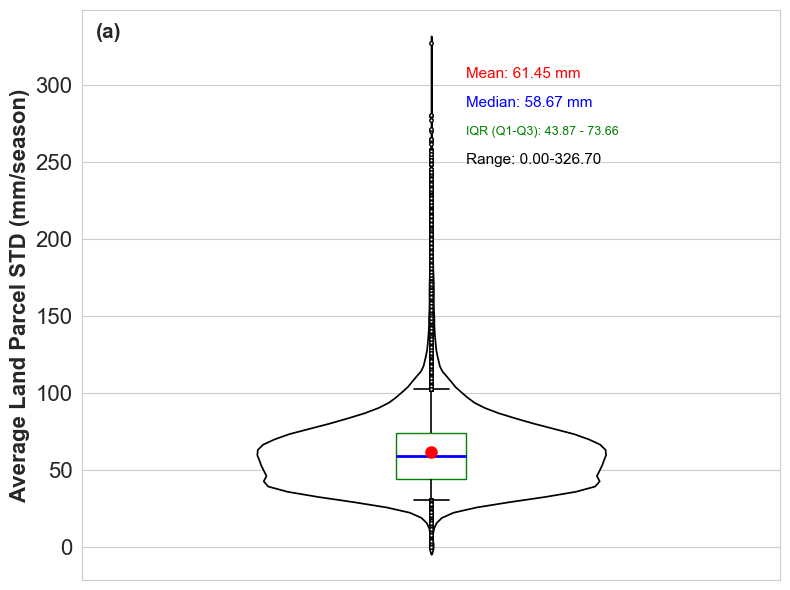

In [12]:
# Define color properties
violin_color = '#ffffff'  # White
boxplot_edge_color = 'green'  # Boxplot outline
boxplot_fill_color = 'white'
mean_marker_color = 'red'
median_line_color = 'blue'

# Define the path to the CSV files for the section-year using the wildcard (*) to select multiple files that match the pattern.
section_file = 'G:/001Project/Output/Sheets/cleaned_Results/irrigation_wUse/Section_IWU_*.csv'
out_dir = 'G:/001Project/Output/Figures/'

# List of models to process
model_columns = [
    'DISALEXI_DAYMET', 'EEMETRIC_DAYMET', 'GEESEBAL_DAYMET', 'PTJPL_DAYMET', 'SIMS_DAYMET', 'SSEBOP_DAYMET',
    'DISALEXI_gridMET', 'EEMETRIC_gridMET', 'GEESEBAL_gridMET', 'PTJPL_gridMET', 'SIMS_gridMET', 'SSEBOP_gridMET',
    'DISALEXI_IMERG', 'EEMETRIC_IMERG', 'GEESEBAL_IMERG', 'PTJPL_IMERG', 'SIMS_IMERG', 'SSEBOP_IMERG',
    'DISALEXI_NLDAS', 'EEMETRIC_NLDAS', 'GEESEBAL_NLDAS', 'PTJPL_NLDAS', 'SIMS_NLDAS', 'SSEBOP_NLDAS',
    'DISALEXI_PRISM', 'EEMETRIC_PRISM', 'GEESEBAL_PRISM', 'PTJPL_PRISM', 'SIMS_PRISM', 'SSEBOP_PRISM'
]

# Process data
def compute_average_across_years(file_pattern):
    # Collect all data from the CSV files
    all_years_data = []
    for file in glob.glob(file_pattern):
        data = pd.read_csv(file)
        data[model_columns] = data[model_columns].clip(lower=0)  # Ensure no negative values
        all_years_data.append(data[model_columns])

    # Compute the average across all years
    average_data = pd.concat(all_years_data).groupby(level=0).mean()

    # Calculate the variability (standard deviation) for the averaged data
    average_data['STD'] = average_data.std(axis=1)
    return average_data

# Compute the averaged data across all 6 years
average_data = compute_average_across_years(section_file)

# Plot the single violin plot for the averaged STD
fig, ax = plt.subplots(figsize=(8, 6))

# Single violin plot for average STD
sns.violinplot(y=average_data['STD'], width=0.5, inner=None, ax=ax, color=violin_color, edgecolor='black')

# Overlay the boxplot for average STD
sns.boxplot(data=average_data, y='STD', saturation=0.5, width=0.1, color=boxplot_fill_color,
            boxprops={'zorder': 2, 'edgecolor': boxplot_edge_color}, showmeans=True,
            meanprops={'marker': 'o',  # Represent mean by a red "o"
                       'markerfacecolor': mean_marker_color,
                       'markeredgecolor': mean_marker_color,
                       'markersize': '8'},
            medianprops={'color': median_line_color, 'linewidth': 2},  # Represent median by a blue line
            whiskerprops={'color': 'black', 'linewidth': 1.2},
            capprops={'color': 'black', 'linewidth': 1.2},
            whis=[5, 95],
            flierprops={'markeredgecolor': 'black', 'markerfacecolor': 'white', 'markersize': 2.5},
            ax=ax)

# Add labels and text
ax.set_ylabel('Average Land Parcel STD (mm/season)', fontweight='bold', fontsize=16)
ax.tick_params(labelsize=16, which='both', width=2)
ax.text(0.02, 0.95, '(a)', transform=ax.transAxes, fontsize=15, fontweight='bold')

# Add statistical summary
avg_stats = average_data['STD'].describe()
avg_mean = avg_stats['mean']
avg_median = avg_stats['50%']
avg_q1 = avg_stats['25%']
avg_q3 = avg_stats['75%']
avg_min = avg_stats['min']
avg_max = avg_stats['max']

ax.text(0.55, 0.88, f'Mean: {avg_mean:.2f} mm', transform=ax.transAxes, fontsize=11, color='red')
ax.text(0.55, 0.83, f'Median: {avg_median:.2f} mm', transform=ax.transAxes, fontsize=11, color='blue')
ax.text(0.55, 0.78, f'IQR (Q1-Q3): {avg_q1:.2f} - {avg_q3:.2f}', transform=ax.transAxes, fontsize=9, color='green')
ax.text(0.55, 0.73, f'Range: {avg_min:.2f}-{avg_max:.2f}', transform=ax.transAxes, fontsize=11, color='black')

plt.tight_layout()
#plt.savefig(out_dir + "Fig1_Avg_STD_Violin.png", dpi=600, bbox_inches='tight')
plt.show()


## Spatial Aggregation

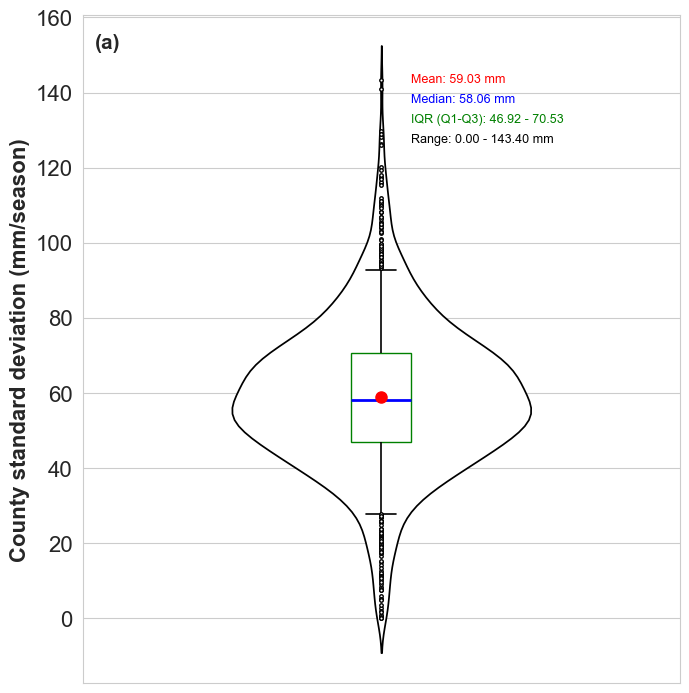

In [29]:
# Define color properties
violin_color = '#ffffff'  # White
boxplot_edge_color = 'green'  # Boxplot outline
boxplot_fill_color = 'white'
mean_marker_color = 'red'
outlier_marker_color = 'black'
median_line_color = 'blue'

# Define the path to the CSV files for the section-year using the wildcard (*) to select multiple files that match the pattern.
section_file = 'G:/001Project/Output/Sheets/cleaned_Results/irrigation_wUse/Section_IWU_*.csv'

# Function to process data and return combined DataFrame
def process_data(file_pattern, groupby_column='COUNTY'):
    all_data = []
    for file in glob.glob(file_pattern):
        # Extract the year from the file name
        year = file.split('_')[-1].split('.')[0]

        data = pd.read_csv(file)
        model_columns = ['DISALEXI_DAYMET', 'EEMETRIC_DAYMET', 'GEESEBAL_DAYMET', 'PTJPL_DAYMET', 'SIMS_DAYMET', 'SSEBOP_DAYMET',
                         'DISALEXI_gridMET', 'EEMETRIC_gridMET', 'GEESEBAL_gridMET', 'PTJPL_gridMET', 'SIMS_gridMET', 'SSEBOP_gridMET',
                         'DISALEXI_IMERG', 'EEMETRIC_IMERG', 'GEESEBAL_IMERG', 'PTJPL_IMERG', 'SIMS_IMERG', 'SSEBOP_IMERG',
                         'DISALEXI_NLDAS', 'EEMETRIC_NLDAS', 'GEESEBAL_NLDAS', 'PTJPL_NLDAS', 'SIMS_NLDAS', 'SSEBOP_NLDAS',
                         'DISALEXI_PRISM', 'EEMETRIC_PRISM', 'GEESEBAL_PRISM', 'PTJPL_PRISM', 'SIMS_PRISM', 'SSEBOP_PRISM']

        # exclude all values less than 0
        data[model_columns] = data[model_columns].clip(lower=0)

        # Group by STATE and COUNTY to get the average for each county in a state
        data = data.groupby(['STATE', groupby_column])[model_columns].mean().reset_index()

        data['STD'] = data[model_columns].std(axis=1)
        data['Year'] = year
        all_data.append(data)

    return pd.concat(all_data)

# Process data for counties
county_data = process_data(section_file, groupby_column='COUNTY')

fig, ax = plt.subplots(figsize=(7, 7.04))

# Plot section variability
sns.violinplot(y=county_data[county_data['STD'] < 200]['STD'], width=0.5, inner=None, ax=ax, color=violin_color, edgecolor='black')
for c in ax.collections:
    if isinstance(c, matplotlib.collections.PathCollection):
        c.set_edgecolor('black')
        c.set_facecolor('#fffff')
        c.set_alpha(1)

sns.boxplot(data=county_data, y='STD', saturation=0.5, width=0.1, color=boxplot_fill_color, boxprops={'zorder': 2, 'edgecolor': boxplot_edge_color}, showmeans=True,
            meanprops={'marker': 'o',
                       'markerfacecolor': mean_marker_color,
                       'markeredgecolor': mean_marker_color,
                       'markersize': '8'},
            medianprops={'color': median_line_color, 'linewidth': 2},
            whiskerprops={'color': 'black', 'linewidth': 1.2},
            capprops={'color': 'black', 'linewidth': 1.2},
            whis=[5, 95],
            flierprops={'markeredgecolor': 'black', 'markerfacecolor': 'white', 'markersize': 2.5},
            ax=ax)

ax.set_ylabel('County standard deviation (mm/season)', fontweight='bold', fontsize=16)
ax.tick_params(labelsize=16, which='both', width=2)
ax.text(0.02, 0.95, '(a)', transform=ax.transAxes, fontsize=15, fontweight='bold')

# Calculate statistics at the county-level
county_stats = county_data['STD'].describe()
county_mean = county_stats['mean']
county_std = county_stats['std']
county_median = county_stats['50%']
county_q1 = county_stats['25%']
county_q3 = county_stats['75%']
county_min = county_stats['min']
county_max = county_stats['max']

# Add labels for mean, interquartile ranges on the top right of the first plot
ax.text(0.55, 0.90, f'Mean: {county_mean:.2f} mm', transform=ax.transAxes, fontsize=9, color='red')
ax.text(0.55, 0.87, f'Median: {county_median:.2f} mm', transform=ax.transAxes, fontsize=9, color='blue')
ax.text(0.55, 0.84, f'IQR (Q1-Q3): {county_q1:.2f} - {county_q3:.2f}', transform=ax.transAxes, fontsize=9, color='green')
ax.text(0.55, 0.81, f'Range: {county_min:.2f} - {county_max:.2f} mm', transform=ax.transAxes, fontsize=9, color='black')

plt.tight_layout()
#plt.savefig(out_dir + "Fig8_HPA_Section_stats.png", dpi=600, bbox_inches='tight')


## Spatial and Temporal Aggregation

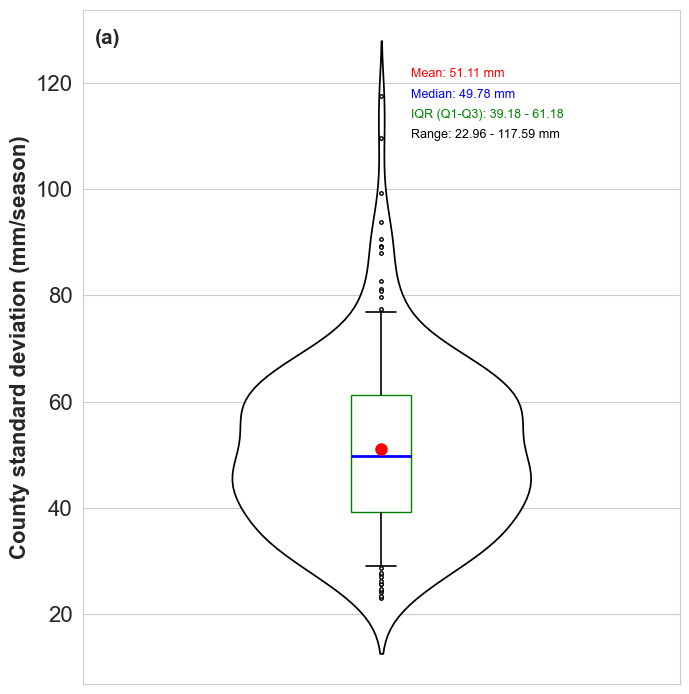

In [14]:
# Define color properties
violin_color = '#ffffff'  # White
boxplot_edge_color = 'green'  # Boxplot outline
boxplot_fill_color = 'white'
mean_marker_color = 'red'
outlier_marker_color = 'black'
median_line_color = 'blue'

# Define the path to the CSV files for the section-year using the wildcard (*) to select multiple files that match the pattern.
section_file = 'G:/001Project/Output/Sheets/cleaned_Results/irrigation_wUse/Section_IWU_*.csv'

# Function to process data and return combined DataFrame
def process_data(file_pattern, groupby_column='COUNTY'):
    all_data = []
    for file in glob.glob(file_pattern):
        data = pd.read_csv(file)
        model_columns = ['DISALEXI_DAYMET', 'EEMETRIC_DAYMET', 'GEESEBAL_DAYMET', 'PTJPL_DAYMET', 'SIMS_DAYMET', 'SSEBOP_DAYMET',
                         'DISALEXI_gridMET', 'EEMETRIC_gridMET', 'GEESEBAL_gridMET', 'PTJPL_gridMET', 'SIMS_gridMET', 'SSEBOP_gridMET',
                         'DISALEXI_IMERG', 'EEMETRIC_IMERG', 'GEESEBAL_IMERG', 'PTJPL_IMERG', 'SIMS_IMERG', 'SSEBOP_IMERG',
                         'DISALEXI_NLDAS', 'EEMETRIC_NLDAS', 'GEESEBAL_NLDAS', 'PTJPL_NLDAS', 'SIMS_NLDAS', 'SSEBOP_NLDAS',
                         'DISALEXI_PRISM', 'EEMETRIC_PRISM', 'GEESEBAL_PRISM', 'PTJPL_PRISM', 'SIMS_PRISM', 'SSEBOP_PRISM']

        # Exclude all values less than 0
        data[model_columns] = data[model_columns].clip(lower=0)

        # Group by STATE and COUNTY to get the average for each county in a state
        data = data.groupby(['STATE', groupby_column])[model_columns].mean().reset_index()

        all_data.append(data)

    # Concatenate all yearly data into one DataFrame
    combined_data = pd.concat(all_data)

    # Now, group by STATE and COUNTY again to calculate the average across the years
    combined_data = combined_data.groupby(['STATE', groupby_column])[model_columns].mean().reset_index()

    # Calculate the standard deviation across the model columns for each county
    combined_data['STD'] = combined_data[model_columns].std(axis=1)

    return combined_data

# Process data for counties
county_data = process_data(section_file, groupby_column='COUNTY')

fig, ax = plt.subplots(figsize=(7, 7.04))

# Plot section variability
sns.violinplot(y=county_data['STD'], width=0.5, inner=None, ax=ax, color=violin_color, edgecolor='black')
sns.boxplot(data=county_data, y='STD', saturation=0.5, width=0.1, color=boxplot_fill_color, boxprops={'zorder': 2, 'edgecolor': boxplot_edge_color}, showmeans=True,
            meanprops={'marker': 'o',
                       'markerfacecolor': mean_marker_color,
                       'markeredgecolor': mean_marker_color,
                       'markersize': '8'},
            medianprops={'color': median_line_color, 'linewidth': 2},
            whiskerprops={'color': 'black', 'linewidth': 1.2},
            capprops={'color': 'black', 'linewidth': 1.2},
            whis=[5, 95],
            flierprops={'markeredgecolor': 'black', 'markerfacecolor': 'white', 'markersize': 2.5},
            ax=ax)

ax.set_ylabel('County standard deviation (mm/season)', fontweight='bold', fontsize=16)
ax.tick_params(labelsize=16, which='both', width=2)
ax.text(0.02, 0.95, '(a)', transform=ax.transAxes, fontsize=15, fontweight='bold')

# Calculate statistics at the county-level
county_stats = county_data['STD'].describe()
county_mean = county_stats['mean']
county_std = county_stats['std']
county_median = county_stats['50%']
county_q1 = county_stats['25%']
county_q3 = county_stats['75%']
county_min = county_stats['min']
county_max = county_stats['max']

# Add labels for mean, interquartile ranges on the top right of the first plot
ax.text(0.55, 0.90, f'Mean: {county_mean:.2f} mm', transform=ax.transAxes, fontsize=9, color='red')
ax.text(0.55, 0.87, f'Median: {county_median:.2f} mm', transform=ax.transAxes, fontsize=9, color='blue')
ax.text(0.55, 0.84, f'IQR (Q1-Q3): {county_q1:.2f} - {county_q3:.2f}', transform=ax.transAxes, fontsize=9, color='green')
ax.text(0.55, 0.81, f'Range: {county_min:.2f} - {county_max:.2f} mm', transform=ax.transAxes, fontsize=9, color='black')

plt.tight_layout()

# Save the table and figure
# table_filename = 'HPA_section_statistics_combined_years.csv'
# table_df.to_csv(table_filename, index=False)

#plt.savefig("Fig8_HPA_Section_stats_combined_years.png", dpi=600, bbox_inches='tight')


## All Combined.

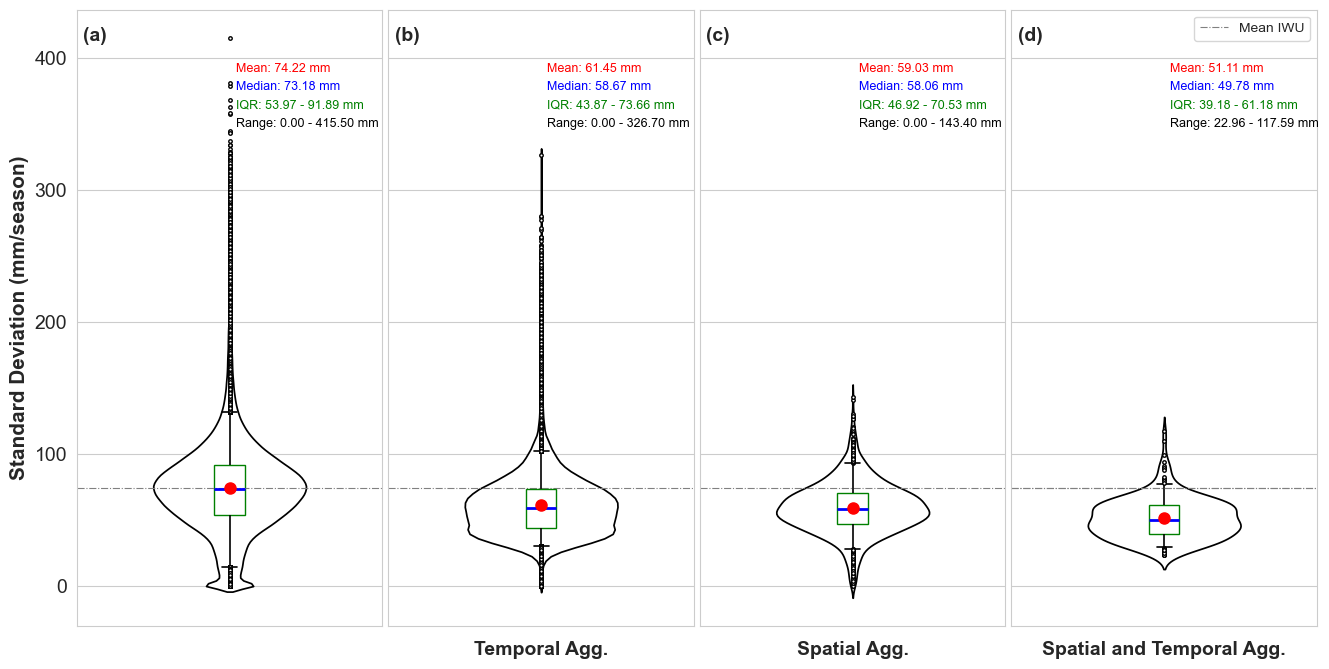

In [30]:
# Define color properties
violin_color = '#ffffff'  # White
boxplot_edge_color = 'green'  # Boxplot outline
boxplot_fill_color = 'white'
mean_marker_color = 'red'
median_line_color = 'blue'

# Define the path to the CSV files
section_file = 'G:/001Project/Output/Sheets/cleaned_Results/irrigation_wUse/Section_IWU_*.csv'

# List of models to process
model_columns = [
    'DISALEXI_DAYMET', 'EEMETRIC_DAYMET', 'GEESEBAL_DAYMET', 'PTJPL_DAYMET', 'SIMS_DAYMET', 'SSEBOP_DAYMET',
    'DISALEXI_gridMET', 'EEMETRIC_gridMET', 'GEESEBAL_gridMET', 'PTJPL_gridMET', 'SIMS_gridMET', 'SSEBOP_gridMET',
    'DISALEXI_IMERG', 'EEMETRIC_IMERG', 'GEESEBAL_IMERG', 'PTJPL_IMERG', 'SIMS_IMERG', 'SSEBOP_IMERG',
    'DISALEXI_NLDAS', 'EEMETRIC_NLDAS', 'GEESEBAL_NLDAS', 'PTJPL_NLDAS', 'SIMS_NLDAS', 'SSEBOP_NLDAS',
    'DISALEXI_PRISM', 'EEMETRIC_PRISM', 'GEESEBAL_PRISM', 'PTJPL_PRISM', 'SIMS_PRISM', 'SSEBOP_PRISM'
]

# Functions to process data
def process_data(file_pattern, groupby_column=None):
    all_data = []
    for file in glob.glob(file_pattern):
        year = file.split('_')[-1].split('.')[0]
        data = pd.read_csv(file)
        data[model_columns] = data[model_columns].clip(lower=0)
        if groupby_column:
            data = data.groupby(groupby_column)[model_columns].mean()
        data['STD'] = data[model_columns].std(axis=1)
        data['Year'] = year
        all_data.append(data)
    return pd.concat(all_data)

def temporal_agg(file_pattern):
    all_years_data = []
    for file in glob.glob(file_pattern):
        data = pd.read_csv(file)
        data[model_columns] = data[model_columns].clip(lower=0)
        all_years_data.append(data[model_columns])
    average_data = pd.concat(all_years_data).groupby(level=0).mean()
    average_data['STD'] = average_data.std(axis=1)
    return average_data

def spatial_agg(file_pattern, groupby_column='COUNTY'):
    all_data = []
    for file in glob.glob(file_pattern):
        year = file.split('_')[-1].split('.')[0]
        data = pd.read_csv(file)
        data[model_columns] = data[model_columns].clip(lower=0)
        data = data.groupby(['STATE', groupby_column])[model_columns].mean().reset_index()
        data['STD'] = data[model_columns].std(axis=1)
        all_data.append(data)
    return pd.concat(all_data)

def process_spatial_temporal_data(file_pattern, groupby_column='COUNTY'):
    all_data = []
    for file in glob.glob(file_pattern):
        data = pd.read_csv(file)
        data[model_columns] = data[model_columns].clip(lower=0)
        data = data.groupby(['STATE', groupby_column])[model_columns].mean().reset_index()
        all_data.append(data)
    combined_data = pd.concat(all_data)
    combined_data = combined_data.groupby(['STATE', groupby_column])[model_columns].mean().reset_index()
    combined_data['STD'] = combined_data[model_columns].std(axis=1)
    return combined_data

# Processed data
section_data = process_data(section_file)
temporal_data = temporal_agg(section_file)
spatial_data = spatial_agg(section_file, groupby_column='COUNTY')
spatial_temporal_data = process_spatial_temporal_data(section_file, groupby_column='COUNTY')

# Calculate the mean of section data
section_mean = section_data['STD'].mean()

def add_statistics_text(ax, stats, x=0.52, y_start=0.9):
    """
    Add mean, IQR, and range statistics inside the plot.
    """
    ax.text(x, y_start, f"Mean: {stats['mean']:.2f} mm", transform=ax.transAxes, fontsize=9, color='red')
    ax.text(x, y_start - 0.03, f"Median: {stats['50%']:.2f} mm", transform=ax.transAxes, fontsize=9, color='blue')
    ax.text(x, y_start - 0.06, f"IQR: {stats['25%']:.2f} - {stats['75%']:.2f} mm", transform=ax.transAxes, fontsize=9, color='green')
    ax.text(x, y_start - 0.09, f"Range: {stats['min']:.2f} - {stats['max']:.2f} mm", transform=ax.transAxes, fontsize=9, color='black')


# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(16, 8), gridspec_kw={'wspace': 0.02}, sharey=True)

# (a) Section Variability
sns.violinplot(
    y=section_data[section_data['STD'] < 200]['STD'],
    width=0.5,
    inner=None,
    ax=axes[0],
    color=violin_color,
    edgecolor='black'
)
sns.boxplot(
    data=section_data,
    y='STD',
    saturation=0.5,
    width=0.1,
    color=boxplot_fill_color,
    boxprops={'zorder': 2, 'edgecolor': boxplot_edge_color},
    showmeans=True,
    meanprops={'marker': 'o', 'markerfacecolor': mean_marker_color, 'markeredgecolor': mean_marker_color, 'markersize': '8'},
    medianprops={'color': median_line_color, 'linewidth': 2},
    whiskerprops={'color': 'black', 'linewidth': 1.2},
    capprops={'color': 'black', 'linewidth': 1.2},
    whis=[5, 95],
    flierprops={'markeredgecolor': 'black', 'markerfacecolor': 'white', 'markersize': 2.5},
    ax=axes[0]
)
axes[0].text(0.02, 0.95, '(a)', transform=axes[0].transAxes, fontsize=14, fontweight='bold')
axes[0].set_ylabel('Standard Deviation (mm/season)', fontweight='bold', fontsize=15)
axes[0].tick_params(labelsize=14, which='both', width=2)
add_statistics_text(axes[0], section_data['STD'].describe())

# Add a horizontal line for section_mean on all subplots
for ax in axes:
    ax.axhline(y=section_mean, color='grey', linestyle='-.', linewidth=0.8)


# (b) Temporal Aggregation
sns.violinplot(
    y=temporal_data['STD'],
    width=0.5,
    inner=None,
    ax=axes[1],
    color=violin_color,
    edgecolor='black'
)
sns.boxplot(
    data=temporal_data,
    y='STD',
    saturation=0.5,
    width=0.1,
    color=boxplot_fill_color,
    boxprops={'zorder': 2, 'edgecolor': boxplot_edge_color},
    showmeans=True,
    meanprops={'marker': 'o', 'markerfacecolor': mean_marker_color, 'markeredgecolor': mean_marker_color, 'markersize': '8'},
    medianprops={'color': median_line_color, 'linewidth': 2},
    whiskerprops={'color': 'black', 'linewidth': 1.2},
    capprops={'color': 'black', 'linewidth': 1.2},
    whis=[5, 95],
    flierprops={'markeredgecolor': 'black', 'markerfacecolor': 'white', 'markersize': 2.5},
    ax=axes[1]
)
axes[1].text(0.02, 0.95, '(b)', transform=axes[1].transAxes, fontsize=14, fontweight='bold')
axes[1].set_xlabel('Temporal Agg.', fontweight='bold', fontsize=14)
add_statistics_text(axes[1], temporal_data['STD'].describe())

# (c) Spatial Aggregation
sns.violinplot(
    y=spatial_data[spatial_data['STD'] < 200]['STD'],
    width=0.5,
    inner=None,
    ax=axes[2],
    color=violin_color,
    edgecolor='black'
)
sns.boxplot(
    data=spatial_data,
    y='STD',
    saturation=0.5,
    width=0.1,
    color=boxplot_fill_color,
    boxprops={'zorder': 2, 'edgecolor': boxplot_edge_color},
    showmeans=True,
    meanprops={'marker': 'o', 'markerfacecolor': mean_marker_color, 'markeredgecolor': mean_marker_color, 'markersize': '8'},
    medianprops={'color': median_line_color, 'linewidth': 2},
    whiskerprops={'color': 'black', 'linewidth': 1.2},
    capprops={'color': 'black', 'linewidth': 1.2},
    whis=[5, 95],
    flierprops={'markeredgecolor': 'black', 'markerfacecolor': 'white', 'markersize': 2.5},
    ax=axes[2]
)
axes[2].text(0.02, 0.95, '(c)', transform=axes[2].transAxes, fontsize=14, fontweight='bold')
axes[2].set_xlabel('Spatial Agg.', fontweight='bold', fontsize=14)
add_statistics_text(axes[2], spatial_data['STD'].describe())

# (d) Spatial and Temporal Aggregation
sns.violinplot(
    y=spatial_temporal_data['STD'],
    width=0.5,
    inner=None,
    ax=axes[3],
    color=violin_color,
    edgecolor='black'
)
sns.boxplot(
    data=spatial_temporal_data,
    y='STD',
    saturation=0.5,
    width=0.1,
    color=boxplot_fill_color,
    boxprops={'zorder': 2, 'edgecolor': boxplot_edge_color},
    showmeans=True,
    meanprops={'marker': 'o', 'markerfacecolor': mean_marker_color, 'markeredgecolor': mean_marker_color, 'markersize': '8'},
    medianprops={'color': median_line_color, 'linewidth': 2},
    whiskerprops={'color': 'black', 'linewidth': 1.2},
    capprops={'color': 'black', 'linewidth': 1.2},
    whis=[5, 95],
    flierprops={'markeredgecolor': 'black', 'markerfacecolor': 'white', 'markersize': 2.5},
    ax=axes[3]
)
axes[3].text(0.02, 0.95, '(d)', transform=axes[3].transAxes, fontsize=14, fontweight='bold')
axes[3].set_xlabel('Spatial and Temporal Agg.', fontweight='bold', fontsize=14)
add_statistics_text(axes[3], spatial_temporal_data['STD'].describe())
axes[3].axhline(y=section_mean, color='grey', linestyle='-.', linewidth=0.8, label='Mean IWU')
axes[3].legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig(out_dir + "Fig7_Spatial_and_Temporal_aggregation.png", dpi=600, bbox_inches='tight')
plt.show()
